In [28]:
from pathlib import Path
import pandas as pd
import numpy as np
from pandas import DataFrame, Series
import tensorflow as tf
from tensorflow import keras
from keras import layers
import tensorflow_addons as tfa
import keras_preprocessing


from sklearn.impute import KNNImputer

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from imblearn.combine import SMOTEENN

print(tf.config.list_physical_devices("GPU"))


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [26]:
def read_and_shuffle_data():
    full_data = pd.read_csv(Path().resolve().joinpath("dataset/full_data.csv"))

    full_data[
        ["hypertension", "heart_disease", "ever_married", "smoking_status"]
    ] = full_data[
        [
            "hypertension",
            "heart_disease",
            "ever_married",
            "smoking_status",
        ]
    ].replace(
        {1: "Yes", 0: "No", "Unknown": np.nan}
    )

    shuffled = full_data.sample(frac=1, random_state=0)

    return shuffled


def encode_int(
    data: pd.DataFrame, enc: OrdinalEncoder, categorical_features: list[str]
):
    enc.fit(data[categorical_features])

    data.loc[:, data[categorical_features].columns] = enc.fit_transform(data[categorical_features])

    return data


def decode_int(
    data: pd.DataFrame, enc: OrdinalEncoder, categorical_features: list[str]
):
    data.loc[:, data[categorical_features].columns] = enc.inverse_transform(data[categorical_features])

    return data


def impute_missing(data: DataFrame, header, categorical_features):
    imp_cat = IterativeImputer(estimator=RandomForestClassifier(),
                           initial_strategy='most_frequent',
                           max_iter=10, random_state=0)

    data[categorical_features] = imp_cat.fit_transform(data[categorical_features])

    return data


def resample(data: pd.DataFrame):
    """oversample positive cases with SMOTE and undersample negative with EEN"""
    X = data.drop(columns=["stroke"], axis=1)
    Y = data["stroke"]

    smote_een = SMOTEENN(random_state=0, sampling_strategy="auto")

    # x_resampled, y_resampled = smote_een.fit_resample(X, Y)
    x_resampled, y_resampled = smote_een.fit_resample(X, Y)
    x_resampled["stroke"] = y_resampled

    # return DataFrame(enc.inverse_transform(x_resampled), columns=data.columns)
    return DataFrame(x_resampled, columns=data.columns)


def generate_train_valid_test(shuffled_data_df: DataFrame, header: list, categorical_features: list):
    enc = OrdinalEncoder()

    data_df = encode_int(
        data=shuffled_data_df, enc=enc, categorical_features=categorical_features
    ).copy()

    data_df = impute_missing(data_df, header=header, categorical_features=categorical_features)

    test_set = data_df[4500:]
    train_validation_data = data_df[:4500].sample(frac=1, random_state=0)

    train_set = resample(train_validation_data[:4000])
    validation_set = train_validation_data[4000:]

    # decode the categorical features from ints
    train_df, validation_df, test_df, data_df = [
        decode_int(data=df, enc=enc, categorical_features=categorical_features)
        for df in [train_set, validation_set, test_set, data_df]
    ]

    return train_set, validation_set, test_set, data_df


def prepare_data_tvt(header, categorical_features):
    full_data_shuffled = read_and_shuffle_data()


    train_df, validation_df, test_df, full_data_df = generate_train_valid_test(full_data_shuffled, header, categorical_features)

    test_df.to_csv(
        Path().resolve().joinpath("dataset/test_data.csv"), index=False, header=False
    )

    validation_df.to_csv(
        Path().resolve().joinpath("dataset/validation_data.csv"),
        index=False,
        header=False,
    )

    train_df.to_csv(
        Path().resolve().joinpath("dataset/train_data.csv"), index=False, header=False
    )

    full_data_df.to_csv(
        Path().resolve().joinpath("dataset/full_data_clean.csv"),
        index=False
    )

    return test_df, train_df, validation_df


In [29]:
# prepare data
CSV_HEADER = [
    "gender",
    "age",
    "hypertension",
    "heart_disease",
    "ever_married",
    "work_type",
    "residence_type",
    "avg_glucose_level",
    "bmi",
    "smoking_status",
    "stroke",
]

NUMERIC_FEATURE_NAMES = [
    "age",
    "avg_glucose_level",
    "bmi",
]  # list of numeric feature names

CATEGORICAL_FEATURE_NAMES = [
    "gender",
    "hypertension",
    "heart_disease",
    "ever_married",
    "work_type",
    "residence_type",
    "smoking_status",
]

train_data_path = Path().resolve().joinpath("dataset/train_data.csv")
validation_data_path = Path().resolve().joinpath("dataset/validation_data.csv")
test_data_path = Path().resolve().joinpath("dataset/test_data.csv")

train_data_file = str(train_data_path.absolute())
validation_data_file = str(validation_data_path.absolute())
test_data_file = str(test_data_path.absolute())

train_data = DataFrame()
validation_data = DataFrame()
test_data = DataFrame()

try:
    train_data = pd.read_csv(
        Path().resolve().joinpath("dataset/train_data.csv"), names=CSV_HEADER
    )

    validation_data = pd.read_csv(
        Path().resolve().joinpath("dataset/validation_data.csv"), names=CSV_HEADER
    )

    test_data = pd.read_csv(
        Path().resolve().joinpath("dataset/test_data.csv"), names=CSV_HEADER
    )

except:
    test_data, train_data, validation_data = prepare_data_tvt(header=CSV_HEADER, categorical_features=CATEGORICAL_FEATURE_NAMES)

test_data, train_data, validation_data = prepare_data_tvt(header=CSV_HEADER, categorical_features=CATEGORICAL_FEATURE_NAMES)

print(
    f"Using {len(train_data)} samples for training, {len(validation_data)} for validation, and {len(test_data)} for test"
)

CATEGORICAL_FEATURES_WITH_VOCABULARY = {
    "gender": sorted(list(train_data["gender"].unique())),
    "hypertension": sorted(list(train_data["hypertension"].unique())),
    "heart_disease": sorted(list(train_data["heart_disease"].unique())),
    "ever_married": sorted(list(train_data["ever_married"].unique())),
    "work_type": sorted(list(train_data["work_type"].unique())),
    "residence_type": sorted(list(train_data["residence_type"].unique())),
    "smoking_status": sorted(list(train_data["smoking_status"].unique())),
}

FEATURE_NAMES = NUMERIC_FEATURE_NAMES + CATEGORICAL_FEATURE_NAMES
TARGET_FEATURE_NAME = "stroke"
TARGET_LABELS = ["1", "0"]

MLP_MODEL_PATH = str(Path().resolve().joinpath("model/mlp_model"))
TABTRANSFORMER_MODEL_PATH = str(Path().resolve().joinpath("model/tabtransformer_model"))

/home/haoming/.local/lib/python3.10/site-packages/sklearn/impute/_iterative.py:713: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/tmp/ipykernel_307992/1930397183.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, data[categorical_features].columns] = enc.inverse_transform(data[categorical_features])
/tmp/ipykernel_307992/1930397183.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, data[categorical_features].columns] = enc.inverse_

Using 6467 samples for training, 500 for validation, and 481 for test


In [10]:
# model hyperparameters

LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001
DROPOUT_RATE = 0.1
BATCH_SIZE = 32
NUM_EPOCHS = 100
EPOCHS_TO_WAIT_FOR_IMPROVE = 5

NUM_TRANSFORMER_BLOCKS = 3  # Number of transformer blocks.
NUM_HEADS = 4  # Number of attention heads.
EMBEDDING_DIMS = 16  # Embedding dimensions of the categorical features.
MLP_HIDDEN_UNITS_FACTORS = [
    2,
    1,
]  # MLP hidden layer units, as factors of the number of inputs.
NUM_MLP_BLOCKS = 2  # Number of MLP blocks in the baseline model.




In [11]:
# data proccessing pipeline

target_label_lookup = layers.StringLookup(
    vocabulary=TARGET_LABELS, mask_token=None, num_oov_indices=0
)


def prepare_example(features, target):
    #target_index = target_label_lookup(target)
    target_index = target
    return features, target_index


def get_dataset_from_csv(csv_file_path, batch_size=128, shuffle=False):
    """dataset from, csv"""
    dataset = tf.data.experimental.make_csv_dataset(
        csv_file_path,
        batch_size=batch_size,
        column_names=CSV_HEADER,
        label_name=TARGET_FEATURE_NAME,
        num_epochs=1,
        header=False,
        na_value="?",
        shuffle=shuffle,
    ).map(prepare_example, num_parallel_calls=tf.data.AUTOTUNE, deterministic=False)
    return dataset.cache()


/home/haoming/.local/lib/python3.10/site-packages/numpy/core/numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
2022-09-03 15:12:50.024534: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-03 15:12:51.131293: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1621 MB memory:  -> device: 0, name: NVIDIA GeForce MX150, pci bus id: 0000:01:00.0, compute capability: 6.1


In [12]:
def create_model_inputs():
    """Create model inputs"""
    inputs = {}
    for feature_name in FEATURE_NAMES:
        if feature_name in NUMERIC_FEATURE_NAMES:
            inputs[feature_name] = layers.Input(
                name=feature_name, shape=(), dtype=tf.float32
            )
        else:
            inputs[feature_name] = layers.Input(
                name=feature_name, shape=(), dtype=tf.string
            )
    return inputs


def encode_inputs(inputs, embedding_dims):
    """Encode features"""

    encoded_categorical_feature_list = []
    numerical_feature_list = []

    for feature_name in inputs:
        if feature_name in CATEGORICAL_FEATURE_NAMES:

            # Get the vocabulary of the categorical feature.
            vocabulary = CATEGORICAL_FEATURES_WITH_VOCABULARY[feature_name]

            # Create a lookup to convert string values to an integer indices.
            # Since we are not using a mask token nor expecting any out of vocabulary
            # (oov) token, we set mask_token to None and  num_oov_indices to 0.
            lookup = layers.StringLookup(
                vocabulary=vocabulary,
                mask_token=None,
                num_oov_indices=0,
                output_mode="int",
            )

            # Convert the string input values into integer indices.
            encoded_feature = lookup(inputs[feature_name])

            # Create an embedding layer with the specified dimensions.
            embedding = layers.Embedding(
                input_dim=len(vocabulary), output_dim=embedding_dims
            )

            # Convert the index values to embedding representations.
            encoded_categorical_feature = embedding(encoded_feature)
            encoded_categorical_feature_list.append(encoded_categorical_feature)

        else:

            # Use the numerical features as-is.
            numerical_feature = tf.expand_dims(inputs[feature_name], -1)
            numerical_feature_list.append(numerical_feature)

    print(encoded_categorical_feature_list)

    return encoded_categorical_feature_list, numerical_feature_list


In [13]:
# training and evaluation


def run_experiment(
    model: keras.Model,
    train_data_file,
    test_data_file,
    model_output,
    num_epochs,
    EPOCHS_TO_WAIT_FOR_IMPROVE,
    learning_rate,
    batch_size,
):
    """Implement a training and evaluation procedure"""
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=WEIGHT_DECAY
    )

    train_dataset = get_dataset_from_csv(train_data_file, batch_size, shuffle=True)
    validation_dataset = get_dataset_from_csv(test_data_file, batch_size)

    metrics=[
        keras.metrics.BinaryAccuracy(name='acc'),
        keras.metrics.AUC(name='auc'),
    ],


    #early_stop_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=EPOCHS_TO_WAIT_FOR_IMPROVE)
    # checkpoint_callback = keras.callbacks.ModelCheckpoint(model_output, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

    early_stop_callback = keras.callbacks.EarlyStopping(
        monitor="val_auc", patience=EPOCHS_TO_WAIT_FOR_IMPROVE
    )

    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        model_output,
        monitor="val_auc",
        verbose=1,
        save_best_only=True,
        mode="max",
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.BinaryCrossentropy(),
        metrics=metrics,
    )

    print("Start training the model...")

    history = model.fit(
        train_dataset,
        epochs=num_epochs,
        validation_data=validation_dataset,
        callbacks=[checkpoint_callback, early_stop_callback],
    )

    print("Model training finished")

    _, accuracy, auc = model.evaluate(validation_dataset, verbose=0)

    print(f"Validation accuracy: {round(accuracy * 100, 2)}% AUC: {auc}")

    return history, model


In [14]:
# MLP block
def create_mlp(hidden_units, dropout_rate, activation, normalization_layer, name=None):
    """MLP block"""

    mlp_layers = []
    for units in hidden_units:
        mlp_layers.append(normalization_layer),
        mlp_layers.append(layers.Dense(units, activation=activation))
        mlp_layers.append(layers.Dropout(dropout_rate))

    return keras.Sequential(mlp_layers, name=name)


def create_baseline_model(
    embedding_dims, num_mlp_blocks, mlp_hidden_units_factors, dropout_rate
):
    """MLP model without transformer layers"""

    # Create model inputs.
    inputs = create_model_inputs()
    # encode features.
    encoded_categorical_feature_list, numerical_feature_list = encode_inputs(
        inputs, embedding_dims
    )
    # Concatenate all features.
    features = layers.concatenate(
        encoded_categorical_feature_list + numerical_feature_list
    )
    # Compute Feedforward layer units.
    feedforward_units = [features.shape[-1]]

    # Create several feedforwad layers with skip connections.
    for layer_idx in range(num_mlp_blocks):
        features = create_mlp(
            hidden_units=feedforward_units,
            dropout_rate=dropout_rate,
            activation=keras.activations.gelu,
            normalization_layer=layers.LayerNormalization(epsilon=1e-6),
            name=f"feedforward_{layer_idx}",
        )(features)

    # Compute MLP hidden_units.
    mlp_hidden_units = [
        factor * features.shape[-1] for factor in mlp_hidden_units_factors
    ]
    # Create final MLP.
    features = create_mlp(
        hidden_units=mlp_hidden_units,
        dropout_rate=dropout_rate,
        activation=keras.activations.relu,
        normalization_layer=layers.BatchNormalization(),
        name="MLP",
    )(features)

    # Add a sigmoid as a binary classifer.
    outputs = layers.Dense(units=1, activation="sigmoid", name="sigmoid")(features)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


[<KerasTensor: shape=(None, 16) dtype=float32 (created by layer 'embedding')>, <KerasTensor: shape=(None, 16) dtype=float32 (created by layer 'embedding_1')>, <KerasTensor: shape=(None, 16) dtype=float32 (created by layer 'embedding_2')>, <KerasTensor: shape=(None, 16) dtype=float32 (created by layer 'embedding_3')>, <KerasTensor: shape=(None, 16) dtype=float32 (created by layer 'embedding_4')>, <KerasTensor: shape=(None, 16) dtype=float32 (created by layer 'embedding_5')>, <KerasTensor: shape=(None, 16) dtype=float32 (created by layer 'embedding_6')>]
Total model weights: 68115


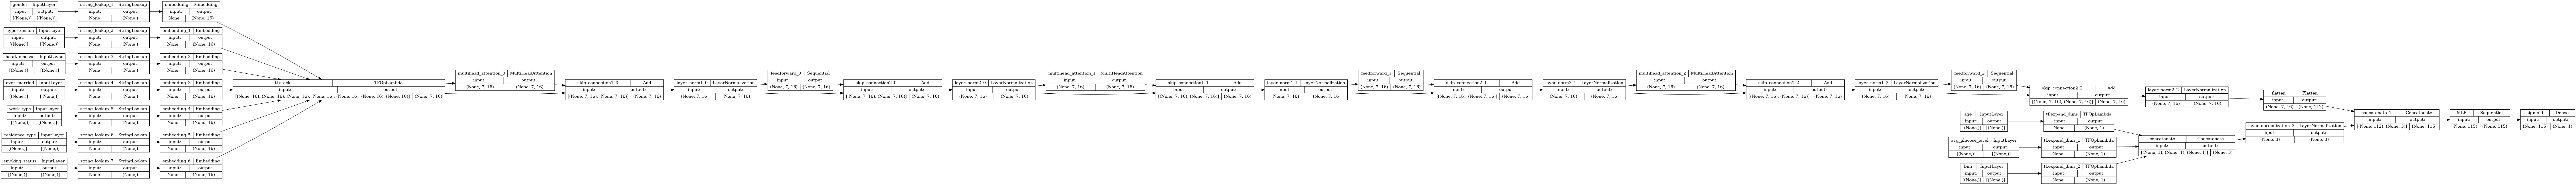

In [15]:
# tabtransformer block


def create_tabtransformer_classifier(
    num_transformer_blocks,
    num_heads,
    embedding_dims,
    mlp_hidden_units_factors,
    dropout_rate,
    use_column_embedding=False,
):

    # Create model inputs.
    inputs = create_model_inputs()
    # encode features.
    encoded_categorical_feature_list, numerical_feature_list = encode_inputs(
        inputs, embedding_dims
    )
    # Stack categorical feature embeddings for the Tansformer.
    encoded_categorical_features = tf.stack(encoded_categorical_feature_list, axis=1)
    # Concatenate numerical features.
    numerical_features = layers.concatenate(numerical_feature_list)

    # Add column embedding to categorical feature embeddings.
    if use_column_embedding:
        num_columns = encoded_categorical_features.shape[1]
        column_embedding = layers.Embedding(
            input_dim=num_columns, output_dim=embedding_dims
        )
        column_indices = tf.range(start=0, limit=num_columns, delta=1)
        encoded_categorical_features = encoded_categorical_features + column_embedding(
            column_indices
        )

    # Create multiple layers of the Transformer block.
    for block_idx in range(num_transformer_blocks):
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embedding_dims,
            dropout=dropout_rate,
            name=f"multihead_attention_{block_idx}",
        )(encoded_categorical_features, encoded_categorical_features)
        # Skip connection 1.
        x = layers.Add(name=f"skip_connection1_{block_idx}")(
            [attention_output, encoded_categorical_features]
        )
        # Layer normalization 1.
        x = layers.LayerNormalization(name=f"layer_norm1_{block_idx}", epsilon=1e-6)(x)
        # Feedforward.
        feedforward_output = create_mlp(
            hidden_units=[embedding_dims],
            dropout_rate=dropout_rate,
            activation=keras.activations.gelu,
            normalization_layer=layers.LayerNormalization(epsilon=1e-6),
            name=f"feedforward_{block_idx}",
        )(x)
        # Skip connection 2.
        x = layers.Add(name=f"skip_connection2_{block_idx}")([feedforward_output, x])
        # Layer normalization 2.
        encoded_categorical_features = layers.LayerNormalization(
            name=f"layer_norm2_{block_idx}", epsilon=1e-6
        )(x)

    # Flatten the "contextualized" embeddings of the categorical features.
    categorical_features = layers.Flatten()(encoded_categorical_features)
    # Apply layer normalization to the numerical features.
    numerical_features = layers.LayerNormalization(epsilon=1e-6)(numerical_features)
    # Prepare the input for the final MLP block.
    features = layers.concatenate([categorical_features, numerical_features])

    # Compute MLP hidden_units.
    mlp_hidden_units = [
        factor * features.shape[-1] for factor in mlp_hidden_units_factors
    ]
    # Create final MLP.
    features = create_mlp(
        hidden_units=mlp_hidden_units,
        dropout_rate=dropout_rate,
        activation=keras.activations.selu,
        normalization_layer=layers.BatchNormalization(),
        name="MLP",
    )(features)

    # Add a sigmoid as a binary classifer.
    outputs = layers.Dense(units=1, activation="sigmoid", name="sigmoid")(features)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


tabtransformer_model = create_tabtransformer_classifier(
    num_transformer_blocks=NUM_TRANSFORMER_BLOCKS,
    num_heads=NUM_HEADS,
    embedding_dims=EMBEDDING_DIMS,
    mlp_hidden_units_factors=MLP_HIDDEN_UNITS_FACTORS,
    dropout_rate=DROPOUT_RATE,
    # use_column_embedding=True
)

print("Total model weights:", tabtransformer_model.count_params())
keras.utils.plot_model(tabtransformer_model, show_shapes=True, rankdir="LR")


/home/haoming/.local/lib/python3.10/site-packages/numpy/core/numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


[<KerasTensor: shape=(None, 16) dtype=float32 (created by layer 'embedding_7')>, <KerasTensor: shape=(None, 16) dtype=float32 (created by layer 'embedding_8')>, <KerasTensor: shape=(None, 16) dtype=float32 (created by layer 'embedding_9')>, <KerasTensor: shape=(None, 16) dtype=float32 (created by layer 'embedding_10')>, <KerasTensor: shape=(None, 16) dtype=float32 (created by layer 'embedding_11')>, <KerasTensor: shape=(None, 16) dtype=float32 (created by layer 'embedding_12')>, <KerasTensor: shape=(None, 16) dtype=float32 (created by layer 'embedding_13')>]
Total model weights: 81233


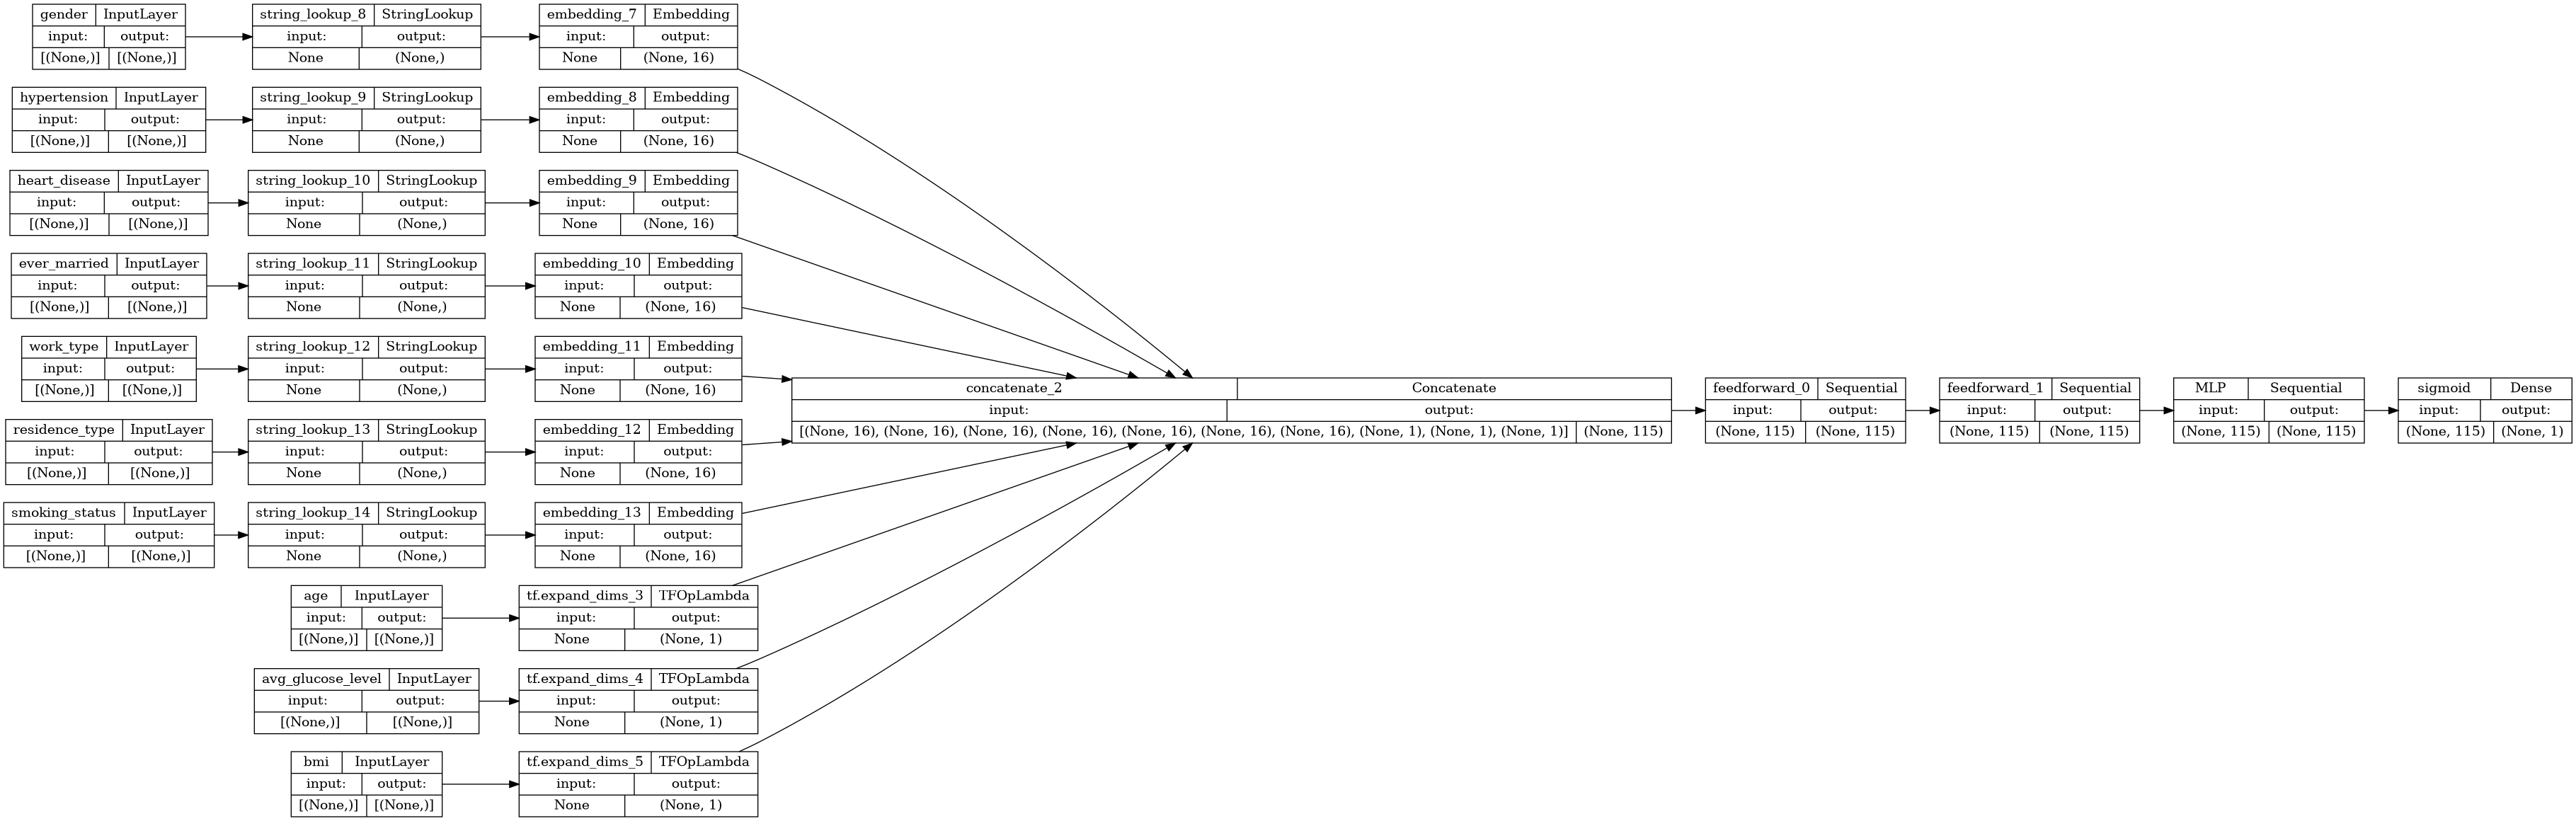

In [16]:
# define a baseline model without transformer layer

baseline_model = create_baseline_model(
    embedding_dims=EMBEDDING_DIMS,
    num_mlp_blocks=NUM_MLP_BLOCKS,
    mlp_hidden_units_factors=MLP_HIDDEN_UNITS_FACTORS,
    dropout_rate=DROPOUT_RATE,
)

print("Total model weights:", baseline_model.count_params())
keras.utils.plot_model(baseline_model, show_shapes=True, rankdir="LR")


In [17]:
EPOCHS_TO_WAIT_FOR_IMPROVE=10

In [18]:
# train baseline model with training set and evaluate with validation set

history, mlp_trained_training = run_experiment(
    model=baseline_model,
    train_data_file=train_data_file,
    test_data_file=validation_data_file,
    model_output=MLP_MODEL_PATH,
    num_epochs=NUM_EPOCHS,
    EPOCHS_TO_WAIT_FOR_IMPROVE=EPOCHS_TO_WAIT_FOR_IMPROVE,
    learning_rate=LEARNING_RATE,
    batch_size=BATCH_SIZE,
)



Start training the model...
Epoch 1/100
    200/Unknown - 7s 12ms/step - loss: 0.4625 - acc: 0.7789 - auc: 0.8439
Epoch 1: val_auc improved from -inf to 0.76691, saving model to /home/haoming/Projects/python/brain-stroke-prediction/model/mlp_model
INFO:tensorflow:Assets written to: /home/haoming/Projects/python/brain-stroke-prediction/model/mlp_model/assets
203/203 [==============================] - 15s 50ms/step - loss: 0.4620 - acc: 0.7792 - auc: 0.8444 - val_loss: 0.7702 - val_acc: 0.5280 - val_auc: 0.7669
Epoch 2/100
202/203 [============================>.] - ETA: 0s - loss: 0.4128 - acc: 0.8037 - auc: 0.8770
Epoch 2: val_auc improved from 0.76691 to 0.76781, saving model to /home/haoming/Projects/python/brain-stroke-prediction/model/mlp_model
INFO:tensorflow:Assets written to: /home/haoming/Projects/python/brain-stroke-prediction/model/mlp_model/assets
203/203 [==============================] - 8s 37ms/step - loss: 0.4131 - acc: 0.8036 - auc: 0.8769 - val_loss: 0.5680 - val_acc: 0

In [19]:
# Now, train on validation set and evalate with test set

history, mlp_trained_validation = run_experiment(
    model=mlp_trained_training,
    train_data_file=validation_data_file,
    test_data_file=test_data_file,
    model_output=MLP_MODEL_PATH,
    num_epochs=NUM_EPOCHS,
    EPOCHS_TO_WAIT_FOR_IMPROVE=EPOCHS_TO_WAIT_FOR_IMPROVE,
    learning_rate=LEARNING_RATE,
    batch_size=BATCH_SIZE,
)


Start training the model...
Epoch 1/100
     13/Unknown - 4s 13ms/step - loss: 0.5243 - acc: 0.8125 - auc: 0.6206
Epoch 1: val_auc improved from -inf to 0.50000, saving model to /home/haoming/Projects/python/brain-stroke-prediction/model/mlp_model
INFO:tensorflow:Assets written to: /home/haoming/Projects/python/brain-stroke-prediction/model/mlp_model/assets
16/16 [==============================] - 11s 479ms/step - loss: 0.4750 - acc: 0.8340 - auc: 0.6298 - val_loss: 0.6076 - val_acc: 0.9397 - val_auc: 0.5000
Epoch 2/100
13/16 [=======================>......] - ETA: 0s - loss: 0.2623 - acc: 0.9231 - auc: 0.7319
Epoch 2: val_auc improved from 0.50000 to 0.58407, saving model to /home/haoming/Projects/python/brain-stroke-prediction/model/mlp_model
INFO:tensorflow:Assets written to: /home/haoming/Projects/python/brain-stroke-prediction/model/mlp_model/assets
16/16 [==============================] - 6s 401ms/step - loss: 0.2507 - acc: 0.9280 - auc: 0.7306 - val_loss: 0.4889 - val_acc: 0.939

In [20]:
EPOCHS_TO_WAIT_FOR_IMPROVE=15

In [21]:
# train tabtransformer model on training data and evaluate on validation data

history, tt_trained_training = run_experiment(
    model=tabtransformer_model,
    train_data_file=train_data_file,
    test_data_file=validation_data_file,
    model_output=TABTRANSFORMER_MODEL_PATH,
    num_epochs=NUM_EPOCHS,
    EPOCHS_TO_WAIT_FOR_IMPROVE=EPOCHS_TO_WAIT_FOR_IMPROVE,
    learning_rate=LEARNING_RATE,
    batch_size=BATCH_SIZE,
)


Start training the model...
Epoch 1/100
    203/Unknown - 13s 24ms/step - loss: 0.5322 - acc: 0.7429 - auc: 0.8181
Epoch 1: val_auc improved from -inf to 0.66119, saving model to /home/haoming/Projects/python/brain-stroke-prediction/model/tabtransformer_model


INFO:tensorflow:Assets written to: /home/haoming/Projects/python/brain-stroke-prediction/model/tabtransformer_model/assets


INFO:tensorflow:Assets written to: /home/haoming/Projects/python/brain-stroke-prediction/model/tabtransformer_model/assets


203/203 [==============================] - 26s 90ms/step - loss: 0.5322 - acc: 0.7429 - auc: 0.8181 - val_loss: 0.8876 - val_acc: 0.4580 - val_auc: 0.6612
Epoch 2/100
202/203 [============================>.] - ETA: 0s - loss: 0.4725 - acc: 0.7799 - auc: 0.8477
Epoch 2: val_auc did not improve from 0.66119
203/203 [==============================] - 6s 28ms/step - loss: 0.4730 - acc: 0.7795 - auc: 0.8474 - val_loss: 0.5789 - val_acc: 0.6640 - val_auc: 0.6536
Epoch 3/100
202/203 [============================>.] - ETA: 0s - loss: 0.4488 - acc: 0.7881 - auc: 0.8605
Epoch 3: val_auc did not improve from 0.66119
203/203 [==============================] - 5s 24ms/step - loss: 0.4494 - acc: 0.7877 - auc: 0.8602 - val_loss: 0.5625 - val_acc: 0.6640 - val_auc: 0.6485
Epoch 4/100
202/203 [============================>.] - ETA: 0s - loss: 0.4307 - acc: 0.7981 - auc: 0.8691
Epoch 4: val_auc did not improve from 0.66119
203/203 [==============================] - 5s 22ms/step - loss: 0.4309 - acc: 0.7

INFO:tensorflow:Assets written to: /home/haoming/Projects/python/brain-stroke-prediction/model/tabtransformer_model/assets


INFO:tensorflow:Assets written to: /home/haoming/Projects/python/brain-stroke-prediction/model/tabtransformer_model/assets


203/203 [==============================] - 16s 78ms/step - loss: 0.4041 - acc: 0.8112 - auc: 0.8830 - val_loss: 0.5893 - val_acc: 0.6340 - val_auc: 0.6651
Epoch 10/100
203/203 [==============================] - ETA: 0s - loss: 0.4012 - acc: 0.8159 - auc: 0.8856
Epoch 10: val_auc improved from 0.66508 to 0.66550, saving model to /home/haoming/Projects/python/brain-stroke-prediction/model/tabtransformer_model


INFO:tensorflow:Assets written to: /home/haoming/Projects/python/brain-stroke-prediction/model/tabtransformer_model/assets


INFO:tensorflow:Assets written to: /home/haoming/Projects/python/brain-stroke-prediction/model/tabtransformer_model/assets


203/203 [==============================] - 19s 92ms/step - loss: 0.4012 - acc: 0.8159 - auc: 0.8856 - val_loss: 0.6215 - val_acc: 0.6040 - val_auc: 0.6655
Epoch 11/100
201/203 [============================>.] - ETA: 0s - loss: 0.3985 - acc: 0.8120 - auc: 0.8869
Epoch 11: val_auc did not improve from 0.66550
203/203 [==============================] - 6s 28ms/step - loss: 0.3989 - acc: 0.8118 - auc: 0.8865 - val_loss: 0.6037 - val_acc: 0.6040 - val_auc: 0.6601
Epoch 12/100
203/203 [==============================] - ETA: 0s - loss: 0.3980 - acc: 0.8134 - auc: 0.8877
Epoch 12: val_auc improved from 0.66550 to 0.66721, saving model to /home/haoming/Projects/python/brain-stroke-prediction/model/tabtransformer_model


INFO:tensorflow:Assets written to: /home/haoming/Projects/python/brain-stroke-prediction/model/tabtransformer_model/assets


INFO:tensorflow:Assets written to: /home/haoming/Projects/python/brain-stroke-prediction/model/tabtransformer_model/assets


203/203 [==============================] - 17s 86ms/step - loss: 0.3980 - acc: 0.8134 - auc: 0.8877 - val_loss: 0.6118 - val_acc: 0.5960 - val_auc: 0.6672
Epoch 13/100
202/203 [============================>.] - ETA: 0s - loss: 0.3944 - acc: 0.8142 - auc: 0.8890
Epoch 13: val_auc did not improve from 0.66721
203/203 [==============================] - 6s 27ms/step - loss: 0.3946 - acc: 0.8140 - auc: 0.8889 - val_loss: 0.6030 - val_acc: 0.6040 - val_auc: 0.6605
Epoch 14/100
203/203 [==============================] - ETA: 0s - loss: 0.3919 - acc: 0.8157 - auc: 0.8902
Epoch 14: val_auc did not improve from 0.66721
203/203 [==============================] - 5s 26ms/step - loss: 0.3919 - acc: 0.8157 - auc: 0.8902 - val_loss: 0.5930 - val_acc: 0.6100 - val_auc: 0.6671
Epoch 15/100
202/203 [============================>.] - ETA: 0s - loss: 0.3926 - acc: 0.8193 - auc: 0.8902
Epoch 15: val_auc did not improve from 0.66721
203/203 [==============================] - 5s 25ms/step - loss: 0.3927 - ac

INFO:tensorflow:Assets written to: /home/haoming/Projects/python/brain-stroke-prediction/model/tabtransformer_model/assets


INFO:tensorflow:Assets written to: /home/haoming/Projects/python/brain-stroke-prediction/model/tabtransformer_model/assets


203/203 [==============================] - 17s 83ms/step - loss: 0.3828 - acc: 0.8241 - auc: 0.8959 - val_loss: 0.5909 - val_acc: 0.6300 - val_auc: 0.6716
Epoch 24/100
203/203 [==============================] - ETA: 0s - loss: 0.3821 - acc: 0.8288 - auc: 0.8962
Epoch 24: val_auc did not improve from 0.67158
203/203 [==============================] - 6s 31ms/step - loss: 0.3821 - acc: 0.8288 - auc: 0.8962 - val_loss: 0.6020 - val_acc: 0.6180 - val_auc: 0.6491
Epoch 25/100
202/203 [============================>.] - ETA: 0s - loss: 0.3849 - acc: 0.8215 - auc: 0.8946
Epoch 25: val_auc did not improve from 0.67158
203/203 [==============================] - 6s 29ms/step - loss: 0.3850 - acc: 0.8214 - auc: 0.8945 - val_loss: 0.6257 - val_acc: 0.6040 - val_auc: 0.6508
Epoch 26/100
202/203 [============================>.] - ETA: 0s - loss: 0.3796 - acc: 0.8249 - auc: 0.8974
Epoch 26: val_auc did not improve from 0.67158
203/203 [==============================] - 6s 28ms/step - loss: 0.3797 - ac

In [22]:
# Now, train tabtransformer model on validation data and evaluate on test data

history, tt_trained_validation = run_experiment(
    model=tt_trained_training,
    train_data_file=validation_data_file,
    test_data_file=test_data_file,
    model_output=TABTRANSFORMER_MODEL_PATH,
    num_epochs=NUM_EPOCHS,
    EPOCHS_TO_WAIT_FOR_IMPROVE=EPOCHS_TO_WAIT_FOR_IMPROVE,
    learning_rate=LEARNING_RATE,
    batch_size=BATCH_SIZE,
)


Start training the model...
Epoch 1/100
     14/Unknown - 8s 24ms/step - loss: 0.5324 - acc: 0.7210 - auc: 0.5949
Epoch 1: val_auc improved from -inf to 0.54352, saving model to /home/haoming/Projects/python/brain-stroke-prediction/model/tabtransformer_model


INFO:tensorflow:Assets written to: /home/haoming/Projects/python/brain-stroke-prediction/model/tabtransformer_model/assets


INFO:tensorflow:Assets written to: /home/haoming/Projects/python/brain-stroke-prediction/model/tabtransformer_model/assets


16/16 [==============================] - 20s 830ms/step - loss: 0.5160 - acc: 0.7400 - auc: 0.5851 - val_loss: 0.3211 - val_acc: 0.9085 - val_auc: 0.5435
Epoch 2/100
15/16 [===========================>..] - ETA: 0s - loss: 0.2753 - acc: 0.9208 - auc: 0.6422
Epoch 2: val_auc improved from 0.54352 to 0.60398, saving model to /home/haoming/Projects/python/brain-stroke-prediction/model/tabtransformer_model


INFO:tensorflow:Assets written to: /home/haoming/Projects/python/brain-stroke-prediction/model/tabtransformer_model/assets


INFO:tensorflow:Assets written to: /home/haoming/Projects/python/brain-stroke-prediction/model/tabtransformer_model/assets


16/16 [==============================] - 12s 823ms/step - loss: 0.2723 - acc: 0.9220 - auc: 0.6453 - val_loss: 0.2636 - val_acc: 0.9314 - val_auc: 0.6040
Epoch 3/100
15/16 [===========================>..] - ETA: 0s - loss: 0.2206 - acc: 0.9208 - auc: 0.8091
Epoch 3: val_auc improved from 0.60398 to 0.70549, saving model to /home/haoming/Projects/python/brain-stroke-prediction/model/tabtransformer_model


INFO:tensorflow:Assets written to: /home/haoming/Projects/python/brain-stroke-prediction/model/tabtransformer_model/assets


INFO:tensorflow:Assets written to: /home/haoming/Projects/python/brain-stroke-prediction/model/tabtransformer_model/assets


16/16 [==============================] - 14s 906ms/step - loss: 0.2206 - acc: 0.9220 - auc: 0.8056 - val_loss: 0.2455 - val_acc: 0.9231 - val_auc: 0.7055
Epoch 4/100
15/16 [===========================>..] - ETA: 0s - loss: 0.2204 - acc: 0.9187 - auc: 0.8093
Epoch 4: val_auc did not improve from 0.70549
16/16 [==============================] - 1s 34ms/step - loss: 0.2189 - acc: 0.9200 - auc: 0.8098 - val_loss: 0.2334 - val_acc: 0.9293 - val_auc: 0.6696
Epoch 5/100
15/16 [===========================>..] - ETA: 0s - loss: 0.2139 - acc: 0.9250 - auc: 0.8201
Epoch 5: val_auc did not improve from 0.70549
16/16 [==============================] - 1s 37ms/step - loss: 0.2128 - acc: 0.9260 - auc: 0.8191 - val_loss: 0.2339 - val_acc: 0.9314 - val_auc: 0.6632
Epoch 6/100
15/16 [===========================>..] - ETA: 0s - loss: 0.1875 - acc: 0.9312 - auc: 0.8738
Epoch 6: val_auc did not improve from 0.70549
16/16 [==============================] - 1s 32ms/step - loss: 0.1880 - acc: 0.9320 - auc: 0.